## Certified privacy- and unlearning-safe training on the OCT-MNIST dataset

Run over different privacy and unlearning parameters and plot the results

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import copy
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import abstract_gradient_training as agt
from abstract_gradient_training import AGTConfig
from abstract_gradient_training import certified_training_utils as ct_utils
from abstract_gradient_training import test_metrics
from labellines import *

sys.path.append('..')
from models.deepmind import DeepMindSmall 
from datasets import oct_mnist

In [2]:
results_dir = ".results/"
seed = 3
notebook_id = f"oct_sweep_poison_{seed}"
# model_path = ".models/medmnist_robust_eps0.01_alpha0.1_meps0.01.ckpt"  # pretrained model path
model_path = ".models/medmnist_robust_eps0.5_alpha0.3_meps0.001.ckpt"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

### Define the nominal config, model and dataloaders

In [3]:
clean_batchsize = 3000
drusen_batchsize = 3000
test_batchsize = 1000

# get the "DeepMindSmall" model, pretrained on the MedMNIST dataset (without class 2, Drusen)
model = DeepMindSmall(1, 1)
model.load_state_dict(torch.load(model_path))
model = model.to(nominal_config.device)

In [5]:
from abstract_gradient_training.poisoning import poison_certified_training

torch.manual_seed(0)

# get dataloaders
dl_clean, dl_test_clean = oct_mnist.get_dataloaders(clean_batchsize, test_batchsize, exclude_classes=[2])
dl_drusen, dl_test_drusen = oct_mnist.get_dataloaders(drusen_batchsize, test_batchsize, exclude_classes=[0, 1, 3])
_, dl_test_all = oct_mnist.get_dataloaders(clean_batchsize, test_batchsize)

# evaluate the pre-trained model
param_n, param_l, param_u = ct_utils.get_parameters(model)
drusen_acc = agt.test_metrics.test_accuracy(param_n, param_l, param_u, *next(iter(dl_test_drusen)), model, ct_utils.propagate_conv_layers)
pretrained_acc_backdoor = agt.test_metrics.test_accuracy(param_n, param_l, param_u, *next(iter(dl_test_drusen)), model, ct_utils.propagate_conv_layers, epsilon=0.001)
print(pretrained_acc_backdoor)
pretrained_acc = drusen_acc[1]
clean_acc = agt.test_metrics.test_accuracy(param_n, param_l, param_u, *next(iter(dl_test_clean)), model, ct_utils.propagate_conv_layers)
all_acc = agt.test_metrics.test_accuracy(param_n, param_l, param_u, *next(iter(dl_test_all)), model, ct_utils.propagate_conv_layers)

print("=========== Pre-trained model accuracy ===========", file=sys.stderr)
print(f"Class 2 (Drusen) : nominal = {drusen_acc[1]:.2g}", file=sys.stderr)
print(f"Classes 0, 1, 3  : nominal = {clean_acc[1]:.2g}", file=sys.stderr)
print(f"All Classes      : nominal = {all_acc[1]:.2g}", file=sys.stderr)

drusen_acc_backdoor = agt.test_metrics.test_accuracy(param_n, param_l, param_u, *next(iter(dl_test_drusen)), model, ct_utils.propagate_conv_layers, epsilon=0.001)
print(f"Class 2 (Drusen) : backdoor = {drusen_acc_backdoor}", file=sys.stderr)

nominal_config = AGTConfig(
    fragsize = 2000,
    learning_rate = 0.05,
    n_epochs = 2,
    forward_bound = "interval",
    device = "cuda:0",
    backward_bound = "interval",
    loss = "binary_cross_entropy",
    log_level="DEBUG",
    lr_decay=5.0,
    lr_min=0.001,
    early_stopping=False,
)

# fine-tune the model using abstract gradient training (keeping the convolutional layers fixed)
conf = copy.deepcopy(nominal_config)
conf.k_poison = 50
conf.epsilon = 0.01
param_l, param_n, param_u = poison_certified_training(
    model, conf, dl_drusen, dl_test_drusen, dl_clean=dl_clean, transform=ct_utils.propagate_conv_layers
)

# evaluate the fine-tuned model
drusen_acc = agt.test_metrics.test_accuracy(param_n, param_l, param_u, *next(iter(dl_test_drusen)), model, ct_utils.propagate_conv_layers)
clean_acc = agt.test_metrics.test_accuracy(param_n, param_l, param_u, *next(iter(dl_test_clean)), model, ct_utils.propagate_conv_layers)
all_acc = agt.test_metrics.test_accuracy(param_n, param_l, param_u, *next(iter(dl_test_all)), model, ct_utils.propagate_conv_layers)

print("=========== Fine-tuned model accuracy + bounds ===========", file=sys.stderr)
print(f"Class 2 (Drusen) : nominal = {drusen_acc[1]:.2g}, certified bound = {drusen_acc[0]:.2g}", file=sys.stderr)
print(f"Classes 0, 1, 3  : nominal = {clean_acc[1]:.2g}, certified bound = {clean_acc[0]:.2g}", file=sys.stderr)
print(f"All Classes      : nominal = {all_acc[1]:.2g}, certified bound = {all_acc[0]:.2g}", file=sys.stderr)

=========== Pre-trained model accuracy ===========
Class 2 (Drusen) : nominal = 0.37
Classes 0, 1, 3  : nominal = 0.83
All Classes      : nominal = 0.71
Class 2 (Drusen) : backdoor = (0.2840000092983246, 0.3680000305175781, 0.4440000355243683)
[AGT] [INFO    ] [20:38:15] =================== Starting Poison Certified Training ===================
[AGT] [DEBUG   ] [20:38:15] 	Optimizer params: n_epochs=2, learning_rate=0.05, l1_reg=0.0, l2_reg=0.0
[AGT] [DEBUG   ] [20:38:15] 	Learning rate schedule: lr_decay=5.0, lr_min=0.001, early_stopping=False
[AGT] [DEBUG   ] [20:38:15] 	Adversary feature-space budget: epsilon=0.01, k_poison=50
[AGT] [DEBUG   ] [20:38:15] 	Adversary label-space budget: label_epsilon=0, label_k_poison=0, poison_target=-1
[AGT] [DEBUG   ] [20:38:15] 	Clipping: gamma=inf, method=clamp
[AGT] [DEBUG   ] [20:38:15] 	Bounding methods: forward=interval, loss=binary_cross_entropy, backward=interval
[AGT] [INFO    ] [20:38:15] Starting epoch 1
[AGT] [DEBUG   ] [20:38:15] Initi

### Helper functions to perform the sweep

In [6]:
def run_with_config(config, backdoor=False):
    """If results for this configuration are already computed, load them from disk. Otherwise, run the certified
    training using AGT, then save and return the results."""
    fname = f"{results_dir}/{notebook_id}_{config.hash()}"
    if os.path.isfile(fname):  # run exists, so return the previous results
        param_l, param_n, param_u = torch.load(fname)
    else:
        # check whether the given config should be either unlearning or privacy training
        assert not (config.k_unlearn and config.k_private)
        torch.manual_seed(seed)
        if config.k_private:
            param_l, param_n, param_u = agt.privacy_certified_training(
                model, config, dl_drusen, dl_test_drusen, dl_public=dl_clean, transform=ct_utils.propagate_conv_layers
            )
        else:
            param_l, param_n, param_u = agt.poison_certified_training(
                model, config, dl_drusen, dl_test_drusen, dl_clean=dl_clean, transform=ct_utils.propagate_conv_layers
            )
        torch.save((param_l, param_n, param_u), fname)
    # get nominal accuracy (on the Drusen class) and percent certified (on the entire test set)
    test_eps = config.epsilon if backdoor else 0.0
    accuracy = test_metrics.test_accuracy(
        param_n, param_l, param_u, *next(iter(dl_test_drusen)), model, ct_utils.propagate_conv_layers, epsilon=test_eps
    )
    del param_l, param_n, param_u
    torch.cuda.empty_cache()
    return accuracy

### Perform the sweep over different gamma and k values

Experiments:

1. Feature poisoning with bounded adversary
2. Label flipping with bounded adversary
3. Feature + label flipping with bounded adversary
4. Feature + label poisoning with unbounded adversary

In [64]:
# experiment 1
k_poisons = list(range(0, 601, 20))

# k_poisons_1 = [0, 50, 100, 150, 200, 250, 300]
# k_poisons_1 = [0, 150, 300, 500]
epsilons_1 = [0.01, 0.02, 0.1]

results_1 = {}

config = copy.deepcopy(nominal_config)

for epsilon in epsilons_1:
    tmp_results = {}
    for k_poison in k_poisons:
        config.k_poison = k_poison
        config.epsilon = epsilon
        tmp_results[k_poison] = run_with_config(config)
    results_1[epsilon] = tmp_results

[AGT] [INFO    ] [22:13:47] =================== Starting Poison Certified Training ===================
[AGT] [DEBUG   ] [22:13:47] 	Optimizer params: n_epochs=2, learning_rate=0.05, l1_reg=0.0, l2_reg=0.0
[AGT] [DEBUG   ] [22:13:47] 	Learning rate schedule: lr_decay=5.0, lr_min=0.001, early_stopping=False
[AGT] [DEBUG   ] [22:13:47] 	Adversary feature-space budget: epsilon=0.01, k_poison=20
[AGT] [DEBUG   ] [22:13:47] 	Adversary label-space budget: label_epsilon=0, label_k_poison=0, poison_target=-1
[AGT] [DEBUG   ] [22:13:47] 	Clipping: gamma=inf, method=clamp
[AGT] [DEBUG   ] [22:13:47] 	Bounding methods: forward=interval, loss=binary_cross_entropy, backward=interval
[AGT] [INFO    ] [22:13:47] Starting epoch 1
[AGT] [DEBUG   ] [22:13:47] Initialising dataloader batchsize to 6000
[AGT] [INFO    ] [22:13:47] Training batch 1: Network eval bounds=(0.37, 0.37, 0.37), W0 Bound=0.0 
[AGT] [INFO    ] [22:13:48] Training batch 2: Network eval bounds=(0.92, 0.94, 0.94), W0 Bound=0.00495 
[AG

In [65]:
# experiment 3
# k_poisons_3 = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
# k_poisons_3 = [0, 500, 1000]
results_3 = {}

config = copy.deepcopy(nominal_config)

for k_poison in k_poisons:
    config.label_k_poison = k_poison
    results_3[k_poison] = run_with_config(config)

[AGT] [INFO    ] [22:22:39] =================== Starting Poison Certified Training ===================
[AGT] [DEBUG   ] [22:22:39] 	Optimizer params: n_epochs=2, learning_rate=0.05, l1_reg=0.0, l2_reg=0.0
[AGT] [DEBUG   ] [22:22:39] 	Learning rate schedule: lr_decay=5.0, lr_min=0.001, early_stopping=False
[AGT] [DEBUG   ] [22:22:39] 	Adversary feature-space budget: epsilon=0, k_poison=0
[AGT] [DEBUG   ] [22:22:39] 	Adversary label-space budget: label_epsilon=0, label_k_poison=20, poison_target=-1
[AGT] [DEBUG   ] [22:22:39] 	Clipping: gamma=inf, method=clamp
[AGT] [DEBUG   ] [22:22:39] 	Bounding methods: forward=interval, loss=binary_cross_entropy, backward=interval
[AGT] [INFO    ] [22:22:39] Starting epoch 1
[AGT] [DEBUG   ] [22:22:39] Initialising dataloader batchsize to 6000
[AGT] [INFO    ] [22:22:39] Training batch 1: Network eval bounds=(0.37, 0.37, 0.37), W0 Bound=0.0 
[AGT] [INFO    ] [22:22:41] Training batch 2: Network eval bounds=(0.92, 0.94, 0.94), W0 Bound=0.00383 
[AGT] 

In [92]:
# experiment 4

# k_poisons_4 = [0, 50, 100, 150, 200, 250, 300]
# k_poisons_4 = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500]
clip_gammas = [0.5, 1.0, 4.0]

results_4 = {}

config = copy.deepcopy(nominal_config)
for clip_gamma in clip_gammas:
    tmp_results = {}
    for k_poison in k_poisons:
        config.k_private = k_poison
        config.clip_gamma = clip_gamma
        tmp_results[k_poison] = run_with_config(config)
    results_4[clip_gamma] = tmp_results

In [91]:
# experiment 5

# k_poisons_5 = [0, 50, 100, 150, 200, 250, 300]
# k_poisons_5 = [0, 50, 100, 150, 300, 350, 400, 450, 500]
epsilons_1 = [0.003, 0.006, 0.009]

results_5 = {}

config = copy.deepcopy(nominal_config)

for epsilon in epsilons_1:
    tmp_results = {}
    for k_poison in k_poisons:
        config.k_poison = k_poison
        config.epsilon = epsilon
        tmp_results[k_poison] = run_with_config(config, backdoor=True)
    results_5[epsilon] = tmp_results

### Plot the results

/vol/bitbucket/ps1623/venv/lib/python3.10/site-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_child0), but could not find a label for it.
  warnings.warn(
/vol/bitbucket/ps1623/venv/lib/python3.10/site-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_child2), but could not find a label for it.
  warnings.warn(
/vol/bitbucket/ps1623/venv/lib/python3.10/site-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_child4), but could not find a label for it.
  warnings.warn(


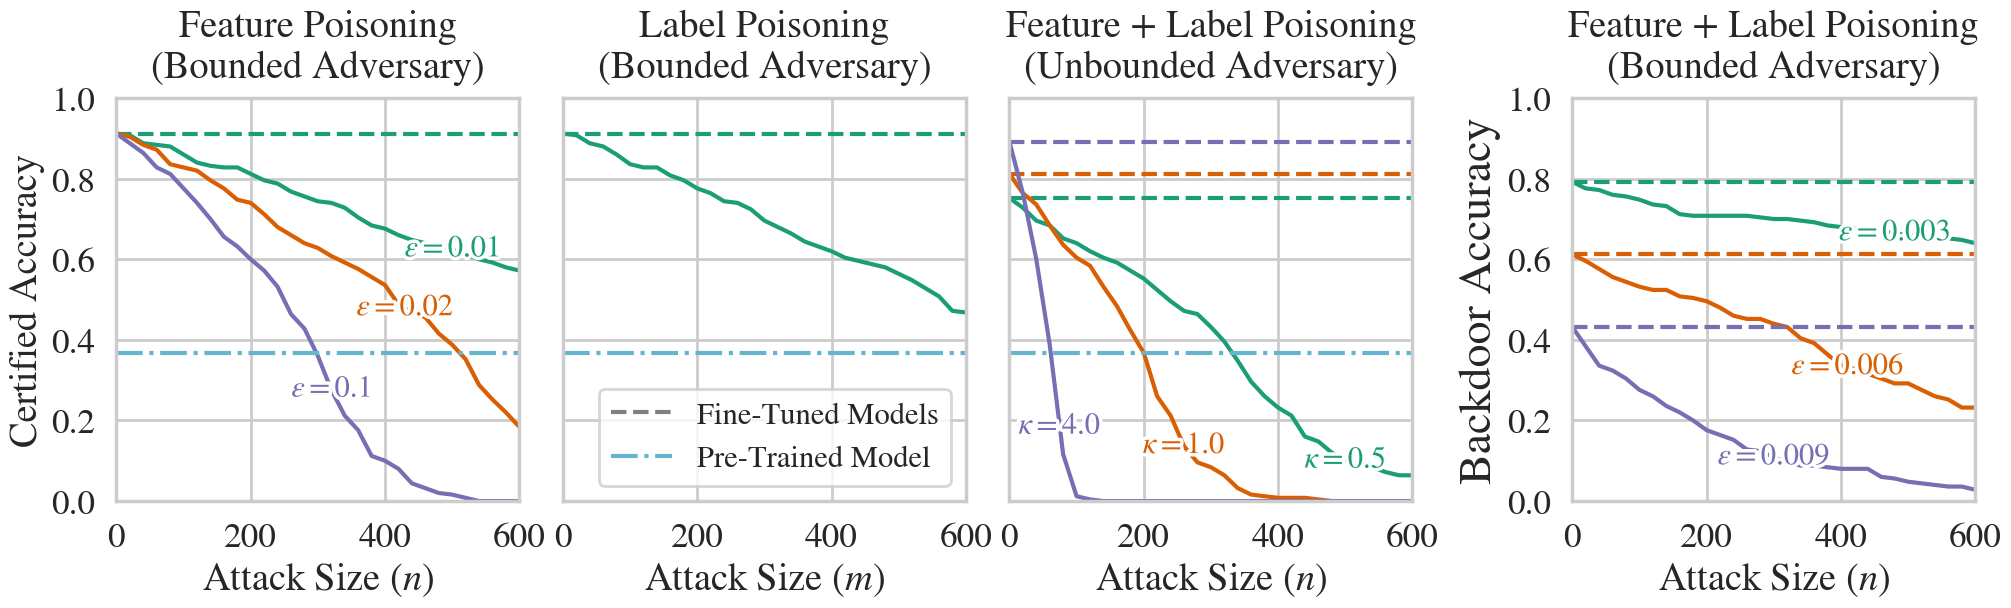

In [133]:
palette = sns.color_palette(palette="Dark2", n_colors=12)
lb_color = list(iter(sns.color_palette(palette="deep")))[-1]
ub_color = list(iter(sns.color_palette(palette="deep")))[-2]

sns.set_theme(context="poster", style="whitegrid", font_scale=1.15)
mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["font.family"] = "STIXGeneral"
labelsize = 22

def plot_experiment(results, ax, type=1, label=r"\epsilon"):
    if type == 1:
        colors = iter(palette)
        for epsilon, results in results.items():
            nom_accs = [res[1] for res in results.values()]
            cert_accs = [res[0] for res in results.values()]
            k_poisons = list(results.keys())
            color = next(colors)
            if epsilon == 0.01:
                ax.plot(k_poisons, nom_accs, linestyle="--", color=color)
            ax.plot(k_poisons, cert_accs, label=fr"${label}={epsilon}$", color=color)
    elif type == 2:
        colors = iter(palette)
        nom_accs = [res[1] for res in results.values()]
        k_poisons = list(results.keys())
        cert_accs = [res[0] for res in results.values()]
        color = next(colors)
        ax.plot(k_poisons, nom_accs, color=color, linestyle="--")
        ax.plot(k_poisons, cert_accs, color=color)
    elif type == 3:
        colors = iter(palette)
        for epsilon, results in results.items():
            nom_accs = [res[1] for res in results.values()]
            cert_accs = [res[0] for res in results.values()]
            k_poisons = list(results.keys())
            color = next(colors)
            ax.plot(k_poisons, nom_accs, color=color, linestyle="--")
            ax.plot(k_poisons, cert_accs, label=fr"${label}={epsilon}$", color=color)
    elif type == 4:
        colors = iter(palette)
        for epsilon, results in results.items():
            cert_accs = [res[0] for res in results.values()]
            nom_accs = [cert_accs[0] for res in results.values()]
            k_poisons = list(results.keys())
            color = next(colors)
            ax.plot(k_poisons, nom_accs, color=color, linestyle="--")
            ax.plot(k_poisons, cert_accs, label=fr"${label}={epsilon}$", color=color)

fig, ax = plt.subplots(
    1,
    5,
    figsize=(20, 15),
    layout="constrained",
    width_ratios=[1, 1, 1, 0.01, 1],
    sharey=False,
    gridspec_kw={"hspace": 0.01, "wspace": 0.01},
)
[a.set_box_aspect(1) for a in ax]

ax[3].set_visible(False)
ax[0].set_title("Feature Poisoning\n(Bounded Adversary)", pad=15)
ax[0].set_xlabel("Attack Size ($n$)")
plot_experiment(results_1, ax[0])
labelLines(ax[0].get_lines(), align=False, drop_label=True, fontsize=labelsize, xvals=[500, 430, 320])

# ax[1].set_title("Label Flipping", pad=15)
# ax[1].set_xlabel("$n=m$")
# plot_experiment(results_2, ax[1])
# labelLines(ax[1].get_lines(), align=False, drop_label=True, fontsize=labelsize)

ax[1].set_title("Label Poisoning\n(Bounded Adversary)", pad=15)
ax[1].set_xlabel("Attack Size ($m$)")
plot_experiment(results_3, ax[1], type=2)

ax[2].set_title("Feature + Label Poisoning\n(Unbounded Adversary)", pad=15)
ax[2].set_xlabel("Attack Size ($n$)")
plot_experiment(results_4, ax[2], label=r"\kappa", type=3)
labelLines(ax[2].get_lines(), align=False, drop_label=True, fontsize=labelsize, xvals=[500, 260, 75])

plot_experiment(results_5, ax[4], label=r"\epsilon", type=4)
labelLines(ax[4].get_lines(), align=False, drop_label=True, fontsize=labelsize, xvals=[480, 410, 300])

ax[4].set_title("Feature + Label Poisoning\n(Bounded Adversary)", pad=15)
ax[4].set_xlabel("Attack Size ($n$)")
ax[4].set_ylabel("Backdoor Accuracy", fontsize="large")
ax[1].plot([], [], color="grey", label="Fine-Tuned Models", linestyle="--")

for i in range(5):
    if i in [1, 2]:
        ax[i].set_yticklabels([])
    ax[i].set_xticks([0, 200, 400, k_poisons[-1]])
    ax[i].set_ylim(0, 1.0)
    ax[i].set_xlim(0, k_poisons[-1])
    # ax[i].set_xticks([0, 50, 100, 150])
    # ax[i].set_xticklabels([0, 50, 100, 150])
    if i == 4:
        continue
    ax[i].axhline(pretrained_acc, label="Pre-Trained Model", color=lb_color, linestyle="-.")


ax[1].legend(loc="lower right", fontsize=labelsize)
ax[0].set_ylabel("Certified Accuracy")

plt.savefig(f".figures/oct_mnist_poisoning.pdf", bbox_inches="tight", dpi=300)

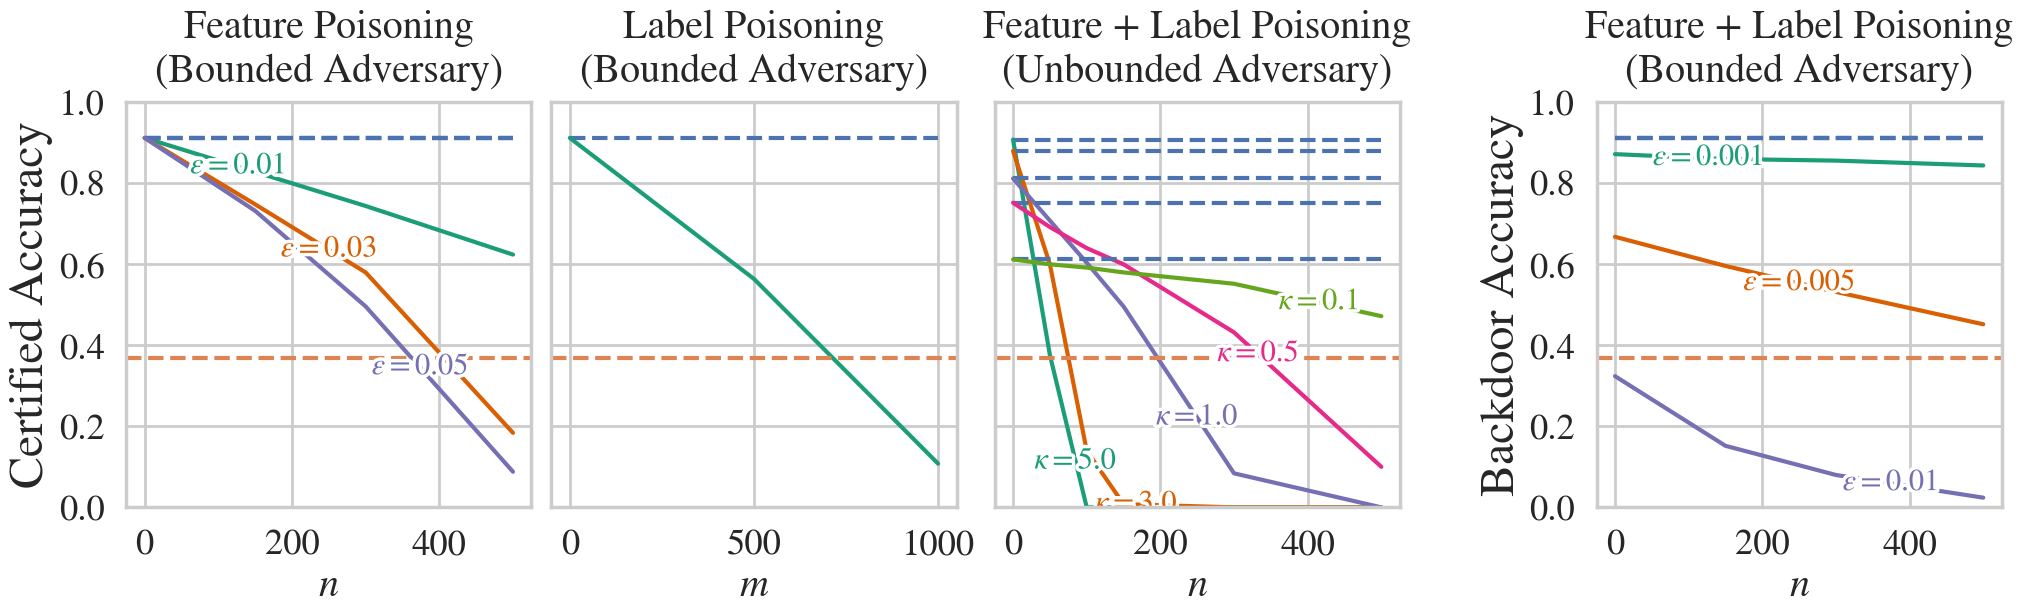
medmnist_robust_eps0.5_alpha0.3_meps0.001.ckpt

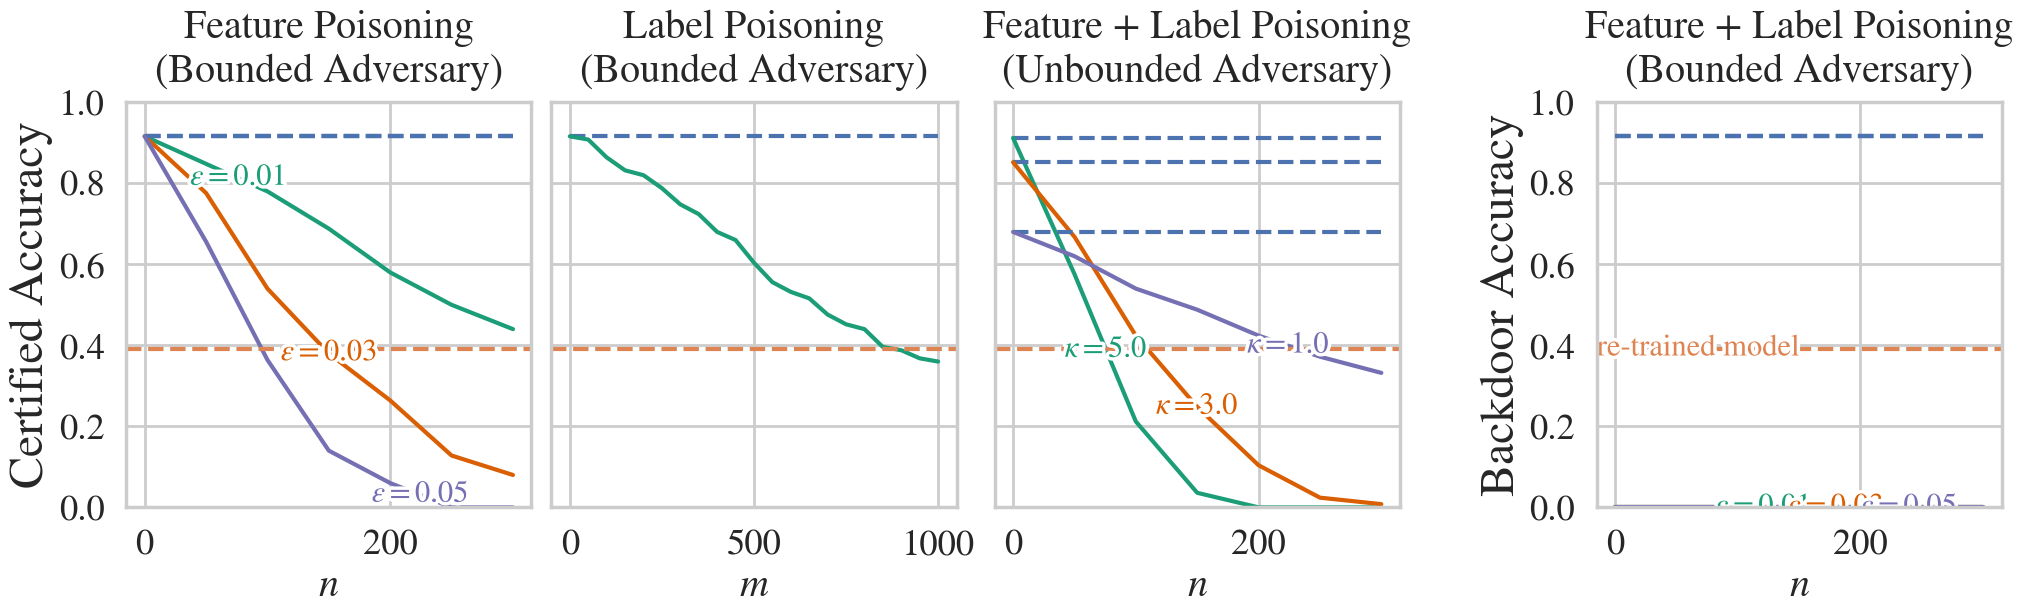

".models/medmnist_robust_eps0.01_alpha0.1_meps0.01.ckpt"